In [21]:
### Predictions du Cd

import numpy as np
import torch
from torch.utils.data import DataLoader
import yaml
from tqdm import tqdm
from Models.GenNet_v4 import AutoencoderSDF
from H5Dataset import H5SDFDataset
import json

with open('/home/amb/bjacques/GenNet/data_split/cd_stats.json', 'r') as f:
    cd_stats = json.load(f)

Cd_min = cd_stats['Cd_min']
Cd_max = cd_stats['Cd_max']

def denormalize(Cd, Cd_max, Cd_min): #dénormalise une valeur Cd
  return Cd * (Cd_max - Cd_min) + Cd_min

# Load config
with open("/home/amb/bjacques/GenNet/config.yaml", "r") as f:
    config = yaml.safe_load(f)

val_path = config['data']['val_path']
model_path = "/home/amb/bjacques/GenNet/Weights/best_model_test9.pt"

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 12
latent_dim = 128
hidden_dim = 512

model = AutoencoderSDF(latent_dim, hidden_dim, dropout=0.0)
model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

# Prepare data
val_dataset = H5SDFDataset(val_path)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

gt_list = []
for batch in val_loader:
    Cd_gt = batch['Cd'].numpy().reshape(-1) 
    gt_list.append(denormalize(Cd_gt, Cd_max, Cd_min))
y_true = np.concatenate(gt_list, axis=0).reshape(-1)  # (N,)

shape_ids = val_dataset.get_ids()

y_true_estate = []
y_true_fastback = []
y_true_notchback = []

for index in range(len(shape_ids)):
    # Classement par type de voiture
    shape_id = shape_ids[index]
    if shape_id.startswith('E'):
            y_true_estate.append(y_true[index])
    elif shape_id.startswith('F'):
            y_true_fastback.append(y_true[index])
    elif shape_id.startswith('N'):
            y_true_notchback.append(y_true[index])
    else:
        print(f"ID inconnu : {shape_id}")


Cd_estate = []
Cd_notchback = []
Cd_fastback = []
Cd_full = []


with torch.no_grad():
    for batch in tqdm(val_loader):
        points = batch['points'].to(device)
        sdf = batch['sdf'].to(device)
        ids = batch['shape_id']
        
        _, Cd_pred_batch, _ = model(points, sdf)
        
        B = len(ids)
        for i in range(B):
            shape_id = ids[i]
            Cd_pred = denormalize(Cd_pred_batch[i].cpu().item(), Cd_max, Cd_min)

            # Classement par type de voiture
            if shape_id.startswith('E'):
                Cd_estate.append(Cd_pred)
            elif shape_id.startswith('F'):
                Cd_fastback.append(Cd_pred)
            elif shape_id.startswith('N'):
                Cd_notchback.append(Cd_pred)
            else:
                print(f"ID inconnu : {shape_id}")
            Cd_full.append(Cd_pred)

def MSE(Cd_pred, Cd_true):
    return np.mean((Cd_pred - Cd_true)**2)

def MAE(Cd_pred, Cd_true):
    return np.mean(np.abs(Cd_pred - Cd_true)/np.abs(Cd_true))

def r2_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

# Résultats

print("\n=== Résultats MSE Cd ===")
print(f"MSE Estateback : {MSE(Cd_estate, y_true_estate):.6f} (N={len(Cd_estate)})")
print(f"MSE Fastback   : {MSE(Cd_fastback, y_true_fastback):.6f} (N={len(Cd_fastback)})")
print(f"MSE Notchback  : {MSE(Cd_notchback, y_true_notchback):.6f} (N={len(Cd_notchback)})")
print(f"MSE Full:{MSE(Cd_full, y_true):.6f} (N={len(Cd_full)})")

"""
print("\n=== Résultats MAE Cd ===")
print(f"MAE Estateback : {MAE(Cd_estate, y_true_estate):.6f} (N={len(Cd_estate)})")
print(f"MAE Fastback   : {MAE(Cd_fastback, y_true_fastback):.6f} (N={len(Cd_fastback)})")
print(f"MAE Notchback  : {MAE(Cd_notchback, y_true_notchback):.6f} (N={len(Cd_notchback)})")
print(f"MAE Full:{MAE(Cd_full, y_true):.6f} (N={len(Cd_full)})")

print("\n=== R2 Scores ===")
print(f"R2 Estateback : {r2_score(y_true_estate, Cd_estate):.4f}")
print(f"R2 Fastback   : {r2_score(y_true_fastback, Cd_fastback):.4f}")
print(f"R2 Notchback  : {r2_score(y_true_notchback, Cd_notchback):.4f}")
print(f"R2 Full       : {r2_score(y_true, Cd_full):.4f}")

"""

print(f"model_used GenNet_test9, skip-connections = {False}")



  5%|▌         | 3/59 [01:54<35:34, 38.11s/it]


KeyboardInterrupt: 

In [15]:
##couverture pour le set de test
import numpy as np
import torch
from torch.utils.data import DataLoader
from H5Dataset import H5SDFDataset
import yaml
import json

# Charger le config.yaml
with open("/home/amb/bjacques/GenNet/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

val_path = config['data']['val_path']
batch_size = 12

model_path = "/home/amb/bjacques/GenNet/Weights/Newmodel_2.pt"

# Charger dataset et dataloader
val_dataset = H5SDFDataset(val_path)
shape_ids = val_dataset.get_ids()
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

with open('/home/amb/bjacques/GenNet/data_split/cd_stats.json', 'r') as f:
    cd_stats = json.load(f)

Cd_min = cd_stats['Cd_min']
Cd_max = cd_stats['Cd_max']

def denormalize(Cd, Cd_max, Cd_min):
    return Cd * (Cd_max - Cd_min) + Cd_min

gt_list = []
for batch in val_loader:
    Cd_gt = batch['Cd'].numpy().reshape(-1) 
    gt_list.append(denormalize(Cd_gt, Cd_max, Cd_min))
y_true = np.concatenate(gt_list, axis=0).reshape(-1)  # (N,)

data_path = '/home/amb/bjacques/GenNet/Results/MC_dropout_val.npz'
data = np.load(data_path, allow_pickle = True)
mean_preds = data['Moyennes']
std_preds = data['incertitudes']

# 2) Aplatir les moyennes / sigmas si (N,1)
mu = mean_preds.reshape(-1)          # (N,)
sigma_mc = std_preds.reshape(-1)     # (N,)
eps = 1e-12
sigma_mc = np.clip(sigma_mc, eps, None)

# 3) Calcul de alpha* (fermé) qui minimise la NLL gaussienne
err = y_true - mu                    # (N,)

alpha = np.sqrt(np.mean(err**2) / np.mean(sigma_mc**2))
print(f'alpha = {alpha}')
# 4) Sigmas calibrés et NLL avant/après (optionnel)
sigma_cal =  alpha*sigma_mc

np.savez('/home/amb/bjacques/GenNet/Results/coverage.npz', incertitude = sigma_cal, preds = mu, GT = y_true)

def nll_gauss(y, mu, sigma):
    sigma = np.clip(sigma, eps, None)
    return 0.5*np.log(2*np.pi*sigma**2) + 0.5*((y-mu)**2)/(sigma**2)


nll_test  = np.mean(nll_gauss(y_true, mu, sigma_cal))
print(f"NLL moyenne après  calibration : {nll_test:.6f}")

for k in [1, 2, 3]:
    cover = np.mean(np.abs(err) <= k*sigma_cal)*100
    print(f"Couverture ±{k}σ (attendu ~{[68.3,95.4,99.7][k-1]}%) : {cover:.2f}%")


cpu


alpha = 8.406506538391113
NLL moyenne après  calibration : -3.655000
Couverture ±1σ (attendu ~68.3%) : 71.04%
Couverture ±2σ (attendu ~95.4%) : 92.87%
Couverture ±3σ (attendu ~99.7%) : 98.00%


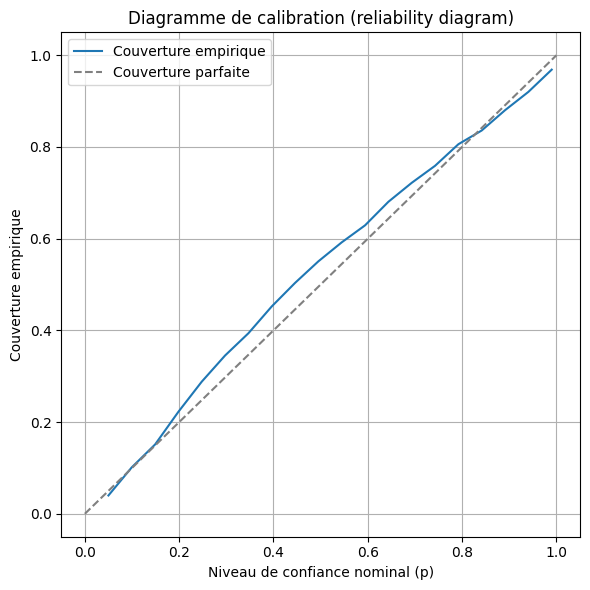

In [ ]:
##relaibility diagramm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# === Niveaux de confiance (exprimés en probabilité) ===
confidence_levels = np.linspace(0.05, 0.99, 20)
z_scores = norm.ppf(0.5 + confidence_levels / 2)  # quantiles bilatéraux

empirical_coverage = []

for z in z_scores:
    lower = mu - z*sigma_cal
    upper = mu + z*sigma_cal
    covered = (y_true >= lower) & (y_true <= upper)
    empirical_coverage.append(np.mean(covered))

empirical_coverage = np.array(empirical_coverage)

# === Tracé ===
plt.figure(figsize=(6,4))
plt.plot(confidence_levels, empirical_coverage, label="Couverture empirique")
plt.plot([0,1], [0,1], '--', color='gray', label="Couverture parfaite")
plt.xlabel("Niveau de confiance nominal (p)")
plt.ylabel("Couverture empirique")
plt.title("Diagramme de calibration (reliability diagram)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from Models.GenNet_skip_v2 import AutoencoderSDF
import json
from sklearn.decomposition import PCA

# === CONFIGURATION ==
model_path = '/home/amb/bjacques/GenNet/Weights/Newmodel_2.pt'
latent_path = '/home/amb/bjacques/GenNet/Results/latent_val.npz'


with open('/home/amb/bjacques/GenNet/data_split/cd_stats.json', 'r') as f:
    cd_stats = json.load(f)

Cd_min = cd_stats['Cd_min']
Cd_max = cd_stats['Cd_max']

def denormalize(Cd, Cd_max, Cd_min): #dénormalise une valeur Cd
  return Cd * (Cd_max - Cd_min) + Cd_min

latent_dim = 128
hidden_dim = 256
dropout = 0.05
epsilon = 0.1  # écart-type du bruit
n_repeat = 100  # nombre de nouveaux z par z initial
MC = 1  # nombre de passes Monte Carlo

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === CHARGEMENT DU MODÈLE ===
model = AutoencoderSDF(latent_dim, hidden_dim, dropout).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # important, pour ne pas activer d'autres modules parasites

# === ACTIVATION DU DROPOUT POUR MC DROPOUT ===
"""
def enable_dropout(m):
    for module in m.modules():
        if isinstance(module, nn.Dropout):
            module.train()

enable_dropout(model)
"""


# === CHARGEMENT DES Z INITIAUX ===
z = np.load(latent_path, allow_pickle=True)['z']  # shape (N, latent_dim)

# PCA sur z pour obtenir les variances des composantes
pca = PCA(n_components=latent_dim)
pca.fit(z)
variances = pca.explained_variance_  # shape: (latent_dim,)

# === GÉNÉRATION DES NOUVEAUX Z ===
z_repeated = np.repeat(z, n_repeat, axis=0)  # shape: (N * n_repeat, latent_dim)
noise = np.random.randn(*z_repeated.shape) * np.sqrt(alpha * variances)  # broadcasting appliqué

z_new = z_repeated + noise
z_new = torch.tensor(z_new, dtype=torch.float32).to(device)

# === CALCUL DE L'INCERTITUDE PAR MC DROPOUT ===
def get_uncertainty(z_single, T=100):
    preds = []
    for _ in range(T):
        with torch.no_grad():
            y_pred = denormalize(model.predict_cd_only(z_single), Cd_max, Cd_min)  # shape (1, 1)
        preds.append(y_pred.cpu().item())  # scalaire
    preds = np.array(preds)
    return preds.mean(), preds.std()

mean_preds, std_preds = [], []

for i in tqdm(range(len(z_new))):
    z_i = z_new[i].unsqueeze(0)  # (1, latent_dim)
    mu, sigma = get_uncertainty(z_i, T=MC)
    mean_preds.append(mu)
    std_preds.append(sigma)

Z = []
preds = []

for i in range(len(mean_preds)):
    if mean_preds[i] < Cd_min:
        Z.append(z_new[i])
        preds.append(mean_preds[i])

#Z_path = '/home/amb/bjacques/GenNet/Results/New_shapes/new_shapes_test5_0.01.npz'
#np.savez(Z_path, latent = Z, predictions = preds)




/home/amb/bjacques/miniconda3/envs/vs_env/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
100%|██████████| 70100/70100 [00:27<00:00, 2558.73it/s]


In [59]:
print(min(mean_preds))

0.22413690388202667


In [20]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from Models.GenNet_skip import AutoencoderSDF
import json

# === CONFIGURATION ==
model_path = '/home/amb/bjacques/GenNet/Weights/best_model_test5.pt'
latent_path = '/home/amb/bjacques/GenNet/Results/latent_val.npz'


with open('/home/amb/bjacques/GenNet/data_split/cd_stats.json', 'r') as f:
    cd_stats = json.load(f)

Cd_min = cd_stats['Cd_min']
Cd_max = cd_stats['Cd_max']

def denormalize(Cd, Cd_max, Cd_min): #dénormalise une valeur Cd
  return Cd * (Cd_max - Cd_min) + Cd_min

latent_dim = 128
hidden_dim = 256
dropout = 0.0
epsilon = 0.01  # écart-type du bruit
n_repeat = 1000  # nombre de nouveaux z par z initial
MC = 1  # nombre de passes Monte Carlo

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === CHARGEMENT DU MODÈLE ===
model = AutoencoderSDF(latent_dim, hidden_dim, dropout).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # important, pour ne pas activer d'autres modules parasites

# === ACTIVATION DU DROPOUT POUR MC DROPOUT ===
"""
def enable_dropout(m):
    for module in m.modules():
        if isinstance(module, nn.Dropout):
            module.train()

enable_dropout(model)
"""

# === CHARGEMENT DES Z INITIAUX ===
z = np.load(latent_path, allow_pickle=True)['z']  # shape (N, latent_dim)

# === GÉNÉRATION DES NOUVEAUX Z ===
z_repeated = np.repeat(z, n_repeat, axis=0)  # shape (N * n_repeat, latent_dim)
noise = np.random.normal(0, epsilon, size=z_repeated.shape)
z_new = z_repeated + noise  # (N * n_repeat, latent_dim)
z_new = torch.tensor(z_new, dtype=torch.float32).to(device)

# === CALCUL DE L'INCERTITUDE PAR MC DROPOUT ===
def get_uncertainty(z_single, T=100):
    preds = []
    for _ in range(T):
        with torch.no_grad():
            y_pred = denormalize(model.predict_cd_only(z_single), Cd_max, Cd_min)  # shape (1, 1)
        preds.append(y_pred.cpu().item())  # scalaire
    preds = np.array(preds)
    return preds.mean(), preds.std()

mean_preds, std_preds = [], []

for i in tqdm(range(len(z_new))):
    z_i = z_new[i].unsqueeze(0)  # (1, latent_dim)
    mu, sigma = get_uncertainty(z_i, T=MC)
    mean_preds.append(mu)
    std_preds.append(sigma)

Z = []
preds = []

for i in range(len(mean_preds)):
    if mean_preds[i] < Cd_min:
        Z.append(z_new[i])
        preds.append(mean_preds[i])

Z_path = '/home/amb/bjacques/GenNet/Results/New_shapes/new_shapes_test5_0.01.npz'
#np.savez(Z_path, latent = Z, predictions = preds)




100%|██████████| 701000/701000 [01:12<00:00, 9647.27it/s] 


In [ ]:
print(f'nouvelle forme:{min(mean_preds)}, Cd_min: {Cd_min}')
print(len(Z))


nouvelle forme:0.20610198378562927, Cd_min: 0.22412799298763275
2199


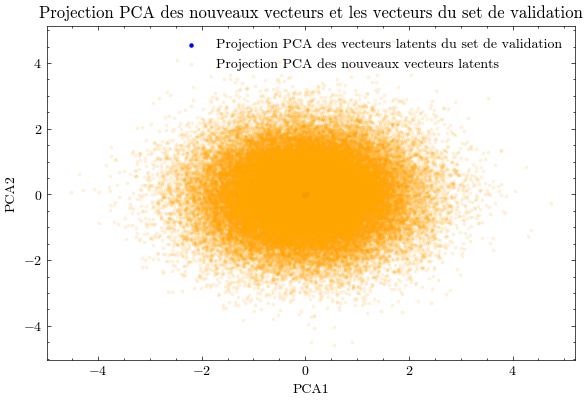

In [17]:
import matplotlib.pyplot as plt
import scienceplots
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Z = np.concatenate([z, z_new], axis = 0)
Z_2d = pca.fit_transform(Z)
z_val_2d = Z_2d[0:len(z)]
z_new_2d = Z_2d[len(z):]

plt.style.use(['science', 'no-latex'])


plt.figure(figsize=(6,4))
plt.scatter(z_val_2d[:,0], z_val_2d[:,1], label = 'Projection PCA des vecteurs latents du set de validation', color = 'blue', s=5, alpha = 1)
plt.scatter(z_new_2d[:,0], z_new_2d[:,1], label = 'Projection PCA des nouveaux vecteurs latents', color = 'orange', s = 3, alpha = 0.1)
plt.legend()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.title("Projection PCA des nouveaux vecteurs et les vecteurs du set de validation")
plt.show()

In [18]:
min(mean_preds)

np.float64(0.07673413775861264)

In [4]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from tqdm import tqdm

# === Chargement des z_train et z_val ===
z_train = np.load('/home/amb/bjacques/GenNet/Results/latent_train.npz')['z']  # shape (N_train, latent_dim)
z_val = np.load('/home/amb/bjacques/GenNet/Results/latent_val.npz')['z']    # shape (N_val, latent_dim)
z_OOD = np.load('/home/amb/bjacques/GenNet/Results/latent_OOD.npz')['z']    # shape (N_OOD, latent_dim)

# === Calcul moyenne et matrice de covariance ===
mu = np.mean(z_train, axis=0)                        # shape (latent_dim,)
cov = np.cov(z_train, rowvar=False)                  # shape (latent_dim, latent_dim)

# === Inversion de la matrice de covariance ===
cov_inv = inv(cov + 1e-6 * np.eye(cov.shape[0]))     # régularisation si mal conditionnée

# === Calcul des distances de Mahalanobis ===
distances = []
for z in z_val:
    d = mahalanobis(z, mu, cov_inv)
    distances.append(d)

distances = np.array(distances)




Corrélation de Spearman : -0.1506
p-value associée : 6.2365e-05


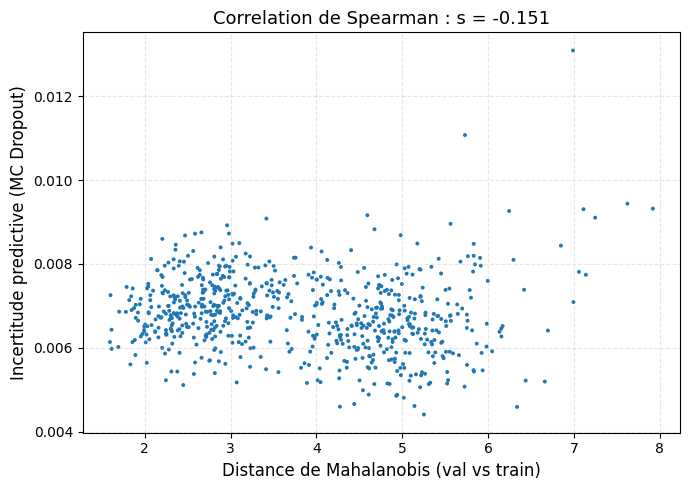

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

alpha = 10  # coefficient de recalibration

# === Chargement des deux distributions ===
mahal_dist = distances  # shape (N,)
sigma_pred = alpha * np.load('/home/amb/bjacques/GenNet/Results/MC_dropout_val.npz', allow_pickle=True)['incertitudes']  # shape (N,)

np.savez('/home/amb/bjacques/GenNet/Results/mahalanobis_vs_incertitude.npz', incertitudes = sigma_pred, mahalanobis = mahal_dist)

# === Vérification de même taille
assert mahal_dist.shape == sigma_pred.shape, "Les deux vecteurs doivent avoir la même taille."

# === Calcul de la corrélation de Spearman
rho, p_value = spearmanr(mahal_dist, sigma_pred)

# === Affichage des résultats
print(f"Corrélation de Spearman : {rho:.4f}")
print(f"p-value associée : {p_value:.4e}")

# === Plot amélioré ===
plt.figure(figsize=(7, 5))
plt.scatter(mahal_dist, sigma_pred, s=8, alpha=1, edgecolor='none')
plt.xlabel('Distance de Mahalanobis (val vs train)', fontsize=12)
plt.ylabel('Incertitude predictive (MC Dropout)', fontsize=12)
plt.title(f"Correlation de Spearman : s = {rho:.3f}", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('/home/amb/bjacques/GenNet/Results/figures/correlation_spearman.pdf')
plt.show()


In [13]:

file = np.load('/home/amb/bjacques/GenNet/Results/mahalanobis_vs_incertitude.npz', allow_pickle = True)
# === Chargement des deux distributions ===
mahal_dist = file['mahalanobis'] # shape (N,)
sigma_pred = file['incertitudes']

print(np.shape(mahal_dist), np.shape(sigma_pred))

(701,) (701,)


Descente de gradient de pour l'optimisation dans l'espacr latent 

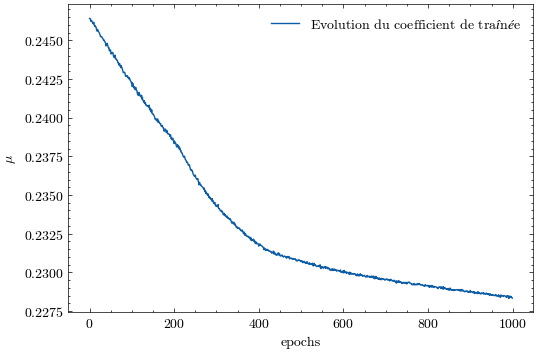

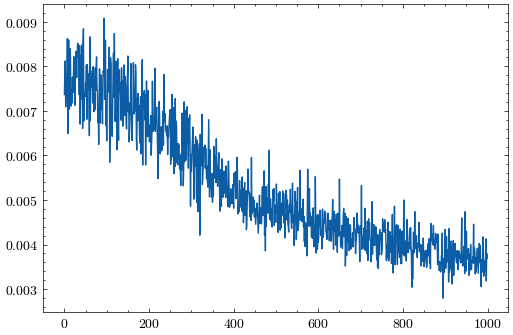

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

file_path = '/home/amb/bjacques/GenNet/Results/z_tracking_new_model_sigma_lambda_1.npz'
data = np.load(file_path, allow_pickle = True)

epochs = data['epoch_array']
mu = data['mu_array']
std = data['std_array']

plt.figure(figsize = (6,4))
plt.plot(epochs,mu, label ='Evolution du coefficient de tra$î$n$é$e')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('$\mu$')
plt.show()

plt.figure(figsize = (6,4))
plt.plot(epochs,std)
plt.show()


In [16]:
print(mu[-1])

0.2245330140938267


In [7]:
import json
with open('/home/amb/bjacques/GenNet/data_split/cd_stats.json', 'r') as f:
    cd_stats = json.load(f)

Cd_min = cd_stats['Cd_min']
Cd_max = cd_stats['Cd_max']

print(Cd_min)

0.22412799298763275


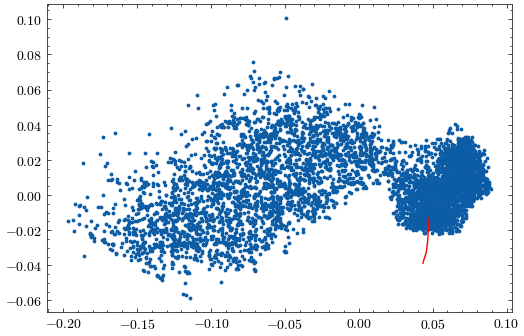

In [35]:
from sklearn.decomposition import PCA

train_latent_path = '/home/amb/bjacques/GenNet/Results/latent_train.npz'
z_train = np.load(train_latent_path, allow_pickle=True)['z']

z_optim = data['z_array']


pca = PCA(n_components=2)

Z = np.concatenate([z_train, z_optim], axis = 0)
Z_2d = pca.fit_transform(Z)
z_train_2d = Z_2d[0:len(z_train)]
z_optim_2d = Z_2d[len(z_train):]

plt.figure(figsize = (6,4))
plt.scatter(z_train_2d[:,0], z_train_2d[:,1], label = 'train', s = 3)
plt.plot(z_optim_2d[:,0], z_optim_2d[:,1], label = 'optimisation', c = 'red')


In [33]:
len(z_optim)

1000

In [ ]:
from Models.GenNet_skip_v2 import AutoencoderSDF
import random
import numpy as np
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from H5Dataset import H5SDFDataset
import yaml
import torch.nn as nn

z_opt = z_optim[-1]
with open("/home/amb/bjacques/GenNet/config.yaml", "r") as f:
    config = yaml.safe_load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
hidden_dim = 256
dropout = 0.05

# Load model
model = AutoencoderSDF(latent_dim, hidden_dim, dropout)
model.load_state_dict(torch.load("/home/amb/bjacques/GenNet/Weights/Newmodel_2.pt"))
model.to(device)
model.eval()




In [ ]:
import numpy as np
import torch
from Models.GenNet_v2 import AutoencoderSDF 

device = torch.device('cpu')
latent_dim = 256
hidden_dim = 512
dropout = 0
model = AutoencoderSDF(latent_dim, hidden_dim, dropout).to(device)
k = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(k)

1843714


In [15]:
import wandb
wandb.login()
api = wandb.Api()

api = wandb.Api()
projects = api.projects("bastienjacques38")
print([p.name for p in projects])

user = api.viewer()
print(user)


[]


TypeError: 'User' object is not callable

In [1]:
import numpy as np
from scipy.spatial import distance
import numpy as np

train_path = '/home/amb/bjacques/GenNet/Results/latent_train.npz'
val_path = '/home/amb/bjacques/GenNet/Results/latent_val.npz'
OOD_path = '/home/amb/bjacques/GenNet/Results/latent_OOD.npz'
latent_train = np.load(train_path, allow_pickle= True)
latent_val = np.load(val_path, allow_pickle=True)
latent_OOD = np.load(OOD_path, allow_pickle=True)

z_train = latent_train['z']
z_val = latent_val['z']
z_OOD = latent_OOD['z']

# mu et Sigma calculés sur le train
mu_train = np.mean(z_train, axis=0)
cov_train = np.cov(z_train, rowvar=False) #Matrice de covariance sur le train
cov_inv = np.linalg.inv(cov_train) # inverse de la matrice de covariance

# Distance de Mahalanobis pour chaque point
d_mahal_val = np.array([distance.mahalanobis(z, mu_train, cov_inv) for z in z_val]) #distance de Mahalanobis pour chaque z de val
d_mahal_OOD = np.array([distance.mahalanobis(z, mu_train, cov_inv) for z in z_OOD]) # distance de Mahalanobis pour chaque z de OOD



In [3]:
print(np.mean(d_mahal_val), np.mean(d_mahal_OOD))

13.787866849007562 148020.0464094741
